In [1]:
from huggingface_hub import login, HfFolder
import os
huggingface_token = os.getenv('HUGGINGFACE_TOKEN')

login(token=huggingface_token, add_to_git_credential=True)

Token is valid (permission: read).
Your token has been saved in your configured git credential helpers (manager,store).
Your token has been saved to C:\Users\Zhenya\.cache\huggingface\token
Login successful


In [2]:
import csv

import os
# You can also adapt this script for your own pseudo-labelling tasks. Pointers for this are left as comments.
import logging
import string
import sys
import time
from dataclasses import dataclass, field
from datetime import timedelta
from pathlib import Path
from typing import Any, Dict, List, Optional, Union

import datasets
import evaluate
import numpy as np
import torch
import transformers
from accelerate import Accelerator, InitProcessGroupKwargs
from accelerate.logging import get_logger
from datasets import (
    DatasetDict,
    IterableDatasetDict,
    load_dataset,
)
from huggingface_hub import HfFolder, Repository, create_repo, get_full_repo_name
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformers import (
    HfArgumentParser,
    Seq2SeqTrainingArguments,
    WhisperConfig,
    WhisperFeatureExtractor,
    WhisperForConditionalGeneration,
    WhisperProcessor,
    WhisperTokenizerFast,
)
from transformers.models.whisper.english_normalizer import EnglishTextNormalizer, BasicTextNormalizer
from transformers.utils import check_min_version
from transformers.utils.versions import require_version


# Will error if the minimal version of Transformers is not installed. Remove at your own risks.
check_min_version("4.34.0.dev0")

require_version("datasets>=2.14.6", "To fix: `pip install --upgrade datasets`")

logger = get_logger(__name__)


In [3]:
from run_pseudo_labelling import (ModelArguments, DataTrainingArguments, shift_tokens_right,
                                  DataCollatorSpeechSeq2SeqWithPadding, log_metric, log_pred)


%load_ext autoreload
%autoreload 1

# Specify that the init_accelerator module should be reloaded
%aimport src.init_accelerator
%aimport src.load_models
%aimport src.prepare_dataset
%aimport src.transcript_csv_utils


from src.transcript_csv_utils import save_transcripts_to_csv, load_transcripts_from_csv, display_transcrips_manual
from src.init_accelerator import prepare_accelerator, create_rep_and_dir
from src.load_models import load_config_feature_ext_tokenizer, load_processor, load_whisper_model
from src.prepare_dataset import prepare_vectorized_dataset, prepare_normilazer

In [4]:
raw_datasets = DatasetDict()
# sampling_rate = 16_000
# 3. Load dataset
all_eval_datasets_list = []

spits_to_load = ['train', 'validation','test']

# 3. Load dataset
raw_datasets = DatasetDict()
token = HfFolder().get_token()

for split in spits_to_load:
    print(split)
    raw_datasets[split] = datasets.load_from_disk(
            f'dataset_saved/mozila_uk/{split}',
        )

    if DEBUG_MODE:=False:
        raw_datasets[split] = raw_datasets[split].select(range(100))
    

train
validation
test


In [5]:
# 1. Parse input arguments
# We keep distinct sets of args, for cleaner separation of model/data/training related args
parser = HfArgumentParser((ModelArguments, DataTrainingArguments, Seq2SeqTrainingArguments))

list_args = [
'--model_name_or_path=./local_whisper_medium',
'--text_column_name=sentence',
'--id_column_name=path',
'--output_dir=dataset_saved/labeled_uk_2',
'--language=uk',
'--per_device_eval_batch_size=35',
'--dtype=float16',
'--dataloader_num_workers=4',
'--preprocessing_num_workers=4',
'--logging_steps=100',
'--max_label_length=128',
'--task=transcribe',

'--generation_num_beams=1',
'--decode_token_ids=False',
'--cache_dir=model_cache/',
'--dataset_cache_dir=cache',
'--preprocessing_only=False',
'--report_to=wandb'
]

model_args, data_args, training_args = parser.parse_args_into_dataclasses(list_args)

In [6]:
accelerator, model_dtype= prepare_accelerator(input_dtype=model_args.dtype,
                                                training_args=training_args, data_args=data_args, logger=logger)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zekamrozek. Use `wandb login --relogin` to force relogin


04/24/2024 19:37:22 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False
04/24/2024 19:37:22 - INFO - __main__ - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=4,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_

In [7]:
if data_args.audio_column_name not in next(iter(raw_datasets.values())).column_names:
    raise ValueError(
        f"--audio_column_name '{data_args.audio_column_name}' not found in dataset"
        f" '{data_args.dataset_name}'. Make sure to set `--audio_column_name` to"
        " the correct audio column - one of"
        f" {', '.join(next(iter(raw_datasets.values())).column_names)}."
    )

if data_args.text_column_name not in next(iter(raw_datasets.values())).column_names:
    raise ValueError(
        f"--text_column_name {data_args.text_column_name} not found in dataset"
        f" '{data_args.dataset_name}'. Make sure to set `--text_column_name` to the"
        " correct text column - one of"
        f" {', '.join(next(iter(raw_datasets.values())).column_names)}."
    )

In [8]:
config, feature_extractor, tokenizer = load_config_feature_ext_tokenizer(
    model_name_or_path="openai/whisper-medium", model_args=model_args)

processor = load_processor(processor_path="openai/whisper-medium", model_args=model_args)

model = load_whisper_model(model_args.model_name_or_path, model_args, dtype=model_dtype)

loading configuration file config.json from cache at model_cache/models--openai--whisper-medium\snapshots\abdf7c39ab9d0397620ccaea8974cc764cd0953e\config.json
Model config WhisperConfig {
  "_name_or_path": "openai/whisper-medium",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "apply_spec_augment": false,
  "architectures": [
    "WhisperForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "begin_suppress_tokens": [
    220,
    50257
  ],
  "bos_token_id": 50257,
  "classifier_proj_size": 256,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 24,
  "decoder_start_token_id": 50258,
  "dropout": 0.0,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 24,
  "eos_token_id": 50257,
  "forced_decoder_ids": [
    [
      1,
      50259
    ],
    [
      2,
      50359
    ],
    [
      3,
      50363
    ]
  ],
  "init_std": 0.02,
 

In [9]:
if model_args.attn_type == "flash_attn":
    model = model.to_bettertransformer()
elif model_args.attn_type not in [None, "flash_attn", "flash_attn_2"]:
    raise ValueError(
        f"Argument `attn_type` is set to {model_args.attn_type}. Should be one of:"
        "1. `None`: default Transformers attention implementation."
        "2. `flash_attn`: Flash Attention through PyTorch SDPA. Requires `torch>=2.0` and `optimum` to be installed. Recommended for hardware where Flash Attention 2 is not supported, e.g. Turing GPUs, (T4, RTX 2080)."
        "3. `flash_attn_2`: Flash Attention 2 through the Flash Attention package https://github.com/Dao-AILab/flash-attention. **Always** recommended on supported hardware (Ampere, Ada, or Hopper GPUs, e.g., A100, RTX 3090, RTX 4090, H100)."
    )

model.eval()

if model.config.decoder_start_token_id is None:
    raise ValueError("Make sure that `config.decoder_start_token_id` is correctly defined")

return_timestamps = data_args.return_timestamps
if hasattr(model.generation_config, "is_multilingual") and model.generation_config.is_multilingual:
    # We need to set the language and task ids for multilingual checkpoints
    tokenizer.set_prefix_tokens(
        language=data_args.language, task=data_args.task, predict_timestamps=return_timestamps
    )
elif data_args.language is not None:
    raise ValueError(
        "Setting language token for an English-only checkpoint is not permitted. The language argument should "
        "only be set for multilingual checkpoints."
    )


In [10]:
normalizer = prepare_normilazer(language=data_args.language, tokenizer=tokenizer)

In [11]:
raw_datasets = raw_datasets.cast_column(
    data_args.audio_column_name,
    datasets.features.Audio(sampling_rate=feature_extractor.sampling_rate),
)

In [12]:
# dataloader_num_workers=training_args.dataloader_num_workers

# language = data_args.language

max_label_length = (
    data_args.max_label_length if data_args.max_label_length is not None else model.config.max_length
)
audio_column_name = data_args.audio_column_name
num_workers = data_args.preprocessing_num_workers

text_column_name = data_args.text_column_name
model_input_name = feature_extractor.model_input_names[0]
id_column_name = data_args.id_column_name

In [13]:
# batch = raw_datasets['train'][0]
# raw_datasets['train'][0][id_column_name]

# sample = batch[audio_column_name]
# inputs = feature_extractor(sample["array"], sampling_rate=sample["sampling_rate"])
# batch[model_input_name] = inputs.get(model_input_name)[0]

# # process targets
# input_str = batch[text_column_name]
# batch["labels"] = tokenizer(input_str, max_length=max_label_length, truncation=True).input_ids

# # record the id of the sample as token ids
# batch["file_id"] = tokenizer(batch[id_column_name], add_special_tokens=False).input_ids

In [14]:
def prepare_dataset(batch, audio_column_name=audio_column_name,
                     model_input_name=model_input_name, text_column_name=text_column_name,
                       max_label_length=max_label_length, id_column_name=id_column_name, feature_extractor=feature_extractor, tokenizer=tokenizer):
    # process audio
    sample = batch[audio_column_name]
    inputs = feature_extractor(sample["array"], sampling_rate=sample["sampling_rate"])
    # process audio length
    batch[model_input_name] = inputs.get(model_input_name)[0]

    # process targets
    input_str = batch[text_column_name]
    batch["labels"] = tokenizer(input_str, max_length=max_label_length, truncation=True).input_ids

    # record the id of the sample as token ids
    batch["file_id"] = tokenizer(batch[id_column_name], add_special_tokens=False).input_ids
    return batch

raw_datasets_features = list(next(iter(raw_datasets.values())).features.keys())
raw_datasets_features.pop(raw_datasets_features.index(text_column_name))


'sentence'

In [15]:
vectorized_datasets = raw_datasets.map(
    prepare_dataset,
    remove_columns=raw_datasets_features,
    num_proc=4,
    desc="preprocess dataset",
)


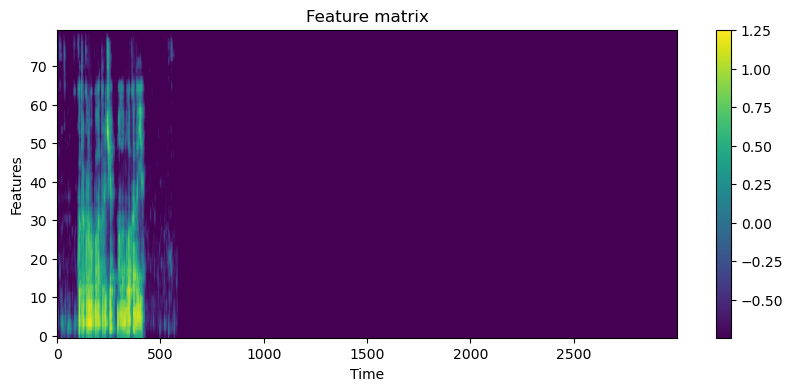

In [16]:
sample_input_feature = vectorized_datasets['train'][0]['input_features']

import librosa
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.imshow(sample_input_feature, aspect='auto', origin='lower')
plt.title('Feature matrix')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Features')
plt.show()

In [17]:
cache = {k: v.cache_files for k, v in vectorized_datasets.items()}
logger.info(f"Data preprocessing finished. Files cached at {cache}.")

04/24/2024 19:37:29 - INFO - __main__ - Data preprocessing finished. Files cached at {'train': [{'filename': 'f:\\distiling_whisper_local\\dataset_saved\\mozila_uk\\train\\cache-b9df47b4295caa65_00000_of_00004.arrow'}, {'filename': 'f:\\distiling_whisper_local\\dataset_saved\\mozila_uk\\train\\cache-b9df47b4295caa65_00001_of_00004.arrow'}, {'filename': 'f:\\distiling_whisper_local\\dataset_saved\\mozila_uk\\train\\cache-b9df47b4295caa65_00002_of_00004.arrow'}, {'filename': 'f:\\distiling_whisper_local\\dataset_saved\\mozila_uk\\train\\cache-b9df47b4295caa65_00003_of_00004.arrow'}], 'validation': [{'filename': 'f:\\distiling_whisper_local\\dataset_saved\\mozila_uk\\validation\\cache-1f93bc4c855a5454_00000_of_00004.arrow'}, {'filename': 'f:\\distiling_whisper_local\\dataset_saved\\mozila_uk\\validation\\cache-1f93bc4c855a5454_00001_of_00004.arrow'}, {'filename': 'f:\\distiling_whisper_local\\dataset_saved\\mozila_uk\\validation\\cache-1f93bc4c855a5454_00002_of_00004.arrow'}, {'filename':

In [18]:
output_dir = training_args.output_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [19]:
# 8. Load Metric
metric = evaluate.load("wer")

def compute_metrics(preds, labels, file_ids):
    # replace padded labels by the padding token
    for idx in range(len(labels)):
        labels[idx][labels[idx] == -100] = tokenizer.pad_token_id

    pred_str = tokenizer.batch_decode(preds, skip_special_tokens=True, decode_with_timestamps=return_timestamps)
    # we do not want to group tokens when computing the metrics
    label_str = tokenizer.batch_decode(labels, skip_special_tokens=True)
    wer_ortho = 100 * metric.compute(predictions=pred_str, references=label_str)

    # normalize everything and re-compute the WER
    norm_pred_str = [normalizer(pred) for pred in pred_str]
    norm_label_str = [normalizer(label) for label in label_str]
    # for logging, we need the pred/labels to match the norm_pred/norm_labels, so discard any filtered samples here
    pred_str = [pred_str[i] for i in range(len(norm_pred_str)) if len(norm_label_str[i]) > 0]
    label_str = [label_str[i] for i in range(len(norm_label_str)) if len(norm_label_str[i]) > 0]
    file_ids = [file_ids[i] for i in range(len(file_ids)) if len(norm_label_str[i]) > 0]
    # filtering step to only evaluate the samples that correspond to non-zero normalized references:
    norm_pred_str = [norm_pred_str[i] for i in range(len(norm_pred_str)) if len(norm_label_str[i]) > 0]
    norm_label_str = [norm_label_str[i] for i in range(len(norm_label_str)) if len(norm_label_str[i]) > 0]

    wer = 100 * metric.compute(predictions=norm_pred_str, references=norm_label_str)

    return {"wer": wer, "wer_ortho": wer_ortho}, pred_str, label_str, norm_pred_str, norm_label_str, file_ids

In [20]:
# 12. Define Training Schedule
per_device_eval_batch_size = int(training_args.per_device_eval_batch_size)

# 14. Define generation arguments - we need to do this before we wrap the models in DDP
# so that we can still access the configs
num_beams = (
    training_args.generation_num_beams
    if training_args.generation_num_beams is not None
    else getattr(model.generation_config, "num_beams", 1)
)

gen_kwargs = {
    "max_length": max_label_length,
    "num_beams": 1,
    "return_timestamps": data_args.return_timestamps,
    "language": data_args.language,
    "task": data_args.task,
}


data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,  # <|startoftranscript|>
    input_padding="longest",
    target_padding="max_length",
    max_target_length=max_label_length,
)

In [21]:

# 15. Prepare everything with accelerate
model = accelerator.prepare(model)

In [22]:
split = 'train'

eval_ids = []

eval_preds = []
eval_decoded_preds = []

eval_labels = []
eval_dataset_text = []

generate_fn = model.module.generate if accelerator.num_processes > 1 else model.generate
output_csv = os.path.join(output_dir, f"batch-testing-transcription.csv")

batch = vectorized_datasets['train'][:2]
batch.keys()


batch_encoded_file_ids = batch.pop("file_id")
batch_dataset_text = batch.pop(data_args.text_column_name)
batch_labels = batch.pop("labels")
X = torch.from_numpy(np.array(batch['input_features'])).to(dtype=model_dtype, device=accelerator.device)


generated_ids = generate_fn(X, **gen_kwargs)
generated_ids

batch_decoded_file_ids = tokenizer.batch_decode(batch_encoded_file_ids, skip_special_tokens=True)

generated_ids = accelerator.pad_across_processes(generated_ids, dim=1, pad_index=tokenizer.pad_token_id)

batch_decoded_pred = tokenizer.batch_decode(
        generated_ids, skip_special_tokens=True, decode_with_timestamps=return_timestamps
    )
batch_decoded_pred


batch_decoded_file_ids, generated_ids, batch_labels, batch_dataset_text, batch_decoded_pred = accelerator.gather_for_metrics(
    (batch_decoded_file_ids, generated_ids, batch_labels, batch_dataset_text, batch_decoded_pred)
)

eval_ids.extend(batch_decoded_file_ids)

eval_preds.extend(generated_ids.cpu().numpy())
eval_decoded_preds.extend(batch_decoded_pred)


eval_labels.extend(batch_labels)
eval_dataset_text.extend(batch_dataset_text)


transcripted_df = save_transcripts_to_csv(output_csv, eval_ids, eval_decoded_preds, eval_dataset_text, eval_preds, eval_labels)
display_transcrips_manual(transcripted_df, cols=['whisper_transcript_decoded', 'text'])

,whisper_transcript_decoded,text
0,"Котра корово багато речі, мало молока дає.","Котра корова богато риче, мало молока дає."
1,Нажди ніколи слушною пори твоя мовчанка може стати ганьбою.,Не жди ніколи слушної пори – твоя мовчанка може стать ганьбою!


In [23]:
dataloader_num_workers = 4
split = 'train'

In [24]:
def eval_step_with_save(split="eval"):
    # ======================== Evaluating ==============================
    eval_ids = []

    eval_preds = []
    eval_decoded_preds = []

    eval_labels = []
    eval_dataset_text = []

    generate_fn = model.module.generate if accelerator.num_processes > 1 else model.generate

    eval_start = time.time()

    eval_loader = DataLoader(
        vectorized_datasets[split],
        batch_size=per_device_eval_batch_size,
        collate_fn=data_collator,
        num_workers=dataloader_num_workers,
        pin_memory=True,
    )

    eval_loader = accelerator.prepare(eval_loader)
    batches = tqdm(eval_loader, desc=f"Evaluating {split}...", disable=not accelerator.is_local_main_process)

    output_csv = os.path.join(output_dir, f"{split}-transcription.csv")

    for step, batch in enumerate(batches):
        batch_encoded_file_ids = batch.pop("file_ids")
        batch_dataset_text = batch.pop('text')
        batch_labels = batch.pop("labels")

        generated_ids = generate_fn(batch["input_features"].to(dtype=model_dtype), **gen_kwargs)
        generated_ids = accelerator.pad_across_processes(generated_ids, dim=1, pad_index=tokenizer.pad_token_id)

        batch_decoded_file_ids = tokenizer.batch_decode(batch_encoded_file_ids, skip_special_tokens=True)

        batch_decoded_pred = tokenizer.batch_decode(
                generated_ids, skip_special_tokens=True, decode_with_timestamps=return_timestamps
            )
        batch_decoded_pred
        # Gather all predictions and targets
        batch_decoded_file_ids, generated_ids, batch_labels, batch_dataset_text, batch_decoded_pred = accelerator.gather_for_metrics(
            (batch_decoded_file_ids, generated_ids, batch_labels, batch_dataset_text, batch_decoded_pred)
        )

        eval_ids.extend(batch_decoded_file_ids)

        eval_preds.extend(generated_ids.cpu().numpy())
        eval_decoded_preds.extend(batch_decoded_pred)


        eval_labels.extend(batch_labels.cpu().numpy())
        eval_dataset_text.extend(batch_dataset_text)


        if step % training_args.logging_steps == 0 and step > 0:
            batches.write(f"Saving transcriptions for split {split} step {step}")
            accelerator.wait_for_everyone()
            transcripted_df = save_transcripts_to_csv(output_csv, eval_ids, eval_decoded_preds, eval_dataset_text, eval_preds, eval_labels)

    accelerator.wait_for_everyone()
    eval_time = time.time() - eval_start

    # compute WER metric for eval sets

    wer_metric, pred_str, label_str, norm_pred_str, norm_label_str, eval_ids = compute_metrics(
        eval_preds, eval_labels, eval_ids
    )
    wer_desc = " ".join([f"Eval {key}: {value} |" for key, value in wer_metric.items()])

    batches.write(f"Saving final transcriptions for split {split}.")
    transcripted_df = save_transcripts_to_csv(output_csv, eval_ids, eval_decoded_preds, eval_dataset_text, eval_preds, eval_labels)
    logger.info(wer_desc)

    raw_datasets[split] = raw_datasets[split].add_column("whisper_transcript_decoded", pred_str)
    raw_datasets[split] = raw_datasets[split].add_column("whisper_transcript", eval_preds)
    raw_datasets[split] = raw_datasets[split].add_column("text", eval_dataset_text)
    raw_datasets[split] = raw_datasets[split].add_column("label", eval_labels)

In [25]:
np.zeros((80, 3000))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
logger.info("***** Running Labelling *****")
logger.info("  Instantaneous batch size per device =" f" {training_args.per_device_eval_batch_size}")
logger.info(
    f"  Total eval batch size (w. parallel & distributed) = {training_args.per_device_eval_batch_size * accelerator.num_processes}"
)

for split in ['train', 'validation', 
              'test'
              ]:#
    eval_preds = eval_step_with_save(split=split)
    accelerator.wait_for_everyone()

raw_datasets.save_to_disk(output_dir, num_proc=num_workers)

accelerator.end_training()

04/24/2024 19:37:40 - INFO - __main__ - ***** Running Labelling *****
04/24/2024 19:37:40 - INFO - __main__ -   Instantaneous batch size per device = 35
04/24/2024 19:37:40 - INFO - __main__ -   Total eval batch size (w. parallel & distributed) = 35


Evaluating train...:   0%|          | 0/680 [00:00<?, ?it/s]

Saving transcriptions for split train step 100
Saving transcriptions for split train step 200
Saving transcriptions for split train step 300
Saving transcriptions for split train step 400
Saving transcriptions for split train step 500
Saving transcriptions for split train step 600
Saving final transcriptions for split train.


04/24/2024 20:12:11 - INFO - __main__ - Eval wer: 21.082207651056407 | Eval wer_ortho: 29.71233152283243 |


Evaluating validation...:   0%|          | 0/280 [00:00<?, ?it/s]

Saving transcriptions for split validation step 100
Saving transcriptions for split validation step 200
Saving final transcriptions for split validation.


04/24/2024 20:26:59 - INFO - __main__ - Eval wer: 19.762400524829573 | Eval wer_ortho: 29.575641602881586 |


Evaluating test...:   0%|          | 0/280 [00:00<?, ?it/s]

Saving transcriptions for split test step 100
Saving transcriptions for split test step 200
Saving final transcriptions for split test.


04/24/2024 20:42:09 - INFO - __main__ - Eval wer: 20.617784623210728 | Eval wer_ortho: 31.190512688303905 |


Saving the dataset (0/4 shards):   0%|          | 0/23799 [00:00<?, ? examples/s]

Saving the dataset (0/4 shards):   0%|          | 0/9786 [00:00<?, ? examples/s]

Saving the dataset (0/4 shards):   0%|          | 0/9791 [00:00<?, ? examples/s]